In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from copy import copy, deepcopy
from scipy import special
import pandas as pd
import matplotlib as mpl
from matplotlib.colors import colorConverter
import time
import pystencils
import sympy
from lbmpy.session import *

In [2]:
# SOR iterative method with objects

# function to find final diffusion gradient with objects
def SOR_with_objects(N, omega, object_array, conc_mat):
    def SOR(conc_mat, omega):
        conc_mat[N - 1] = 1
        
        # left boundary
        for k in range(1, N - 1):
            # if part of object, concentration is zero
            if object_array[k][0] == 1:
                    conc_mat[k][0] = 0
            
            # otherwise: SOR equation
            else:
                conc_mat[k][0] = omega / 4 * (conc_mat[k + 1][0] + conc_mat[k - 1][0] + conc_mat[k][1] + conc_mat[k][N-1]) + (1-omega)*conc_mat[k][0]
        
        # middle of matrix
        for j in range(N - 1):
            for i in range(1, N - 1):
                # if part of object, concentration is zero
                if object_array[i][j] == 1:
                    conc_mat[i][j] = 0
                
                # otherwise: SOR equation
                else:
                    conc_mat[i][j] = (omega / 4) * (conc_mat[i + 1][j] + conc_mat[i - 1][j] + conc_mat[i][j + 1] + conc_mat[i][j - 1]) + (1 - omega) * conc_mat[i][j]
                    if conc_mat[i][j] < 0:
                        conc_mat[i][j] = 0
        # right boundary
        for k in range(1, N - 1):
            # if part of object, concentration is zero
            if object_array[k][N - 1] == 1:
                conc_mat[k][N - 1] = 0
            
            # otherwise: SOR equation
            else:
                conc_mat[k][N - 1] = omega / 4 * (conc_mat[k + 1][N - 1] + conc_mat[k - 1][N - 1] + conc_mat[k][0] + conc_mat[k][N - 2]) + (1 - omega) * conc_mat[k][N - 1]

        return conc_mat

    # initialise parameters
    i = 0 # iterations
    epsilon = 10 ** -5
    diff = 100000 # set to large value    

    # loop until convergence
    while diff > epsilon:
        conc_mat_old = deepcopy(conc_mat)
        conc_mat = SOR(conc_mat, omega)
        diff = np.amax(np.abs(conc_mat - conc_mat_old))
        i += 1
    return diff, i, conc_mat, conc_mat_old

In [9]:
# function to find the neighbours of a new object cell, add to set (so all candidates are unique) 
def get_candidates_SOR(object_loc, object_array, candidates):
    # check if north, south,east, west neighbours are NOT part of object, and add them to candidates
    if object_loc[1]!= N - 1 and object_array[object_loc[0]][object_loc[1] + 1] == 0:
        candidates.add((object_loc[0], object_loc[1] + 1))
    if object_loc[1]!=0 and object_array[object_loc[0]][object_loc[1]-1] == 0:
        candidates.add((object_loc[0], object_loc[1] - 1))
    if object_loc[0]!= N - 1 and object_array[object_loc[0] + 1][object_loc[1]] == 0:
        candidates.add((object_loc[0] + 1, object_loc[1]))
    if object_loc[0]!= 0 and object_array[object_loc[0] - 1][object_loc[1]] == 0:
        candidates.add((object_loc[0] - 1, object_loc[1]))

    return candidates

# function to calculate the SOR of a grid with object, until convergence, with growing object
def SOR_DLA_to_solution(N,eta,omega,iterations):
    # calculate the analytic solution at t=1
    t = 1
    analytic_sol = lambda x, D, t: sum([scipy.special.erfc((1 -x + 2 * i) / (2 * np.sqrt(D * t))) - scipy.special.erfc((1 + x + 2 * i) / (2 * np.sqrt(D * t))) for i in range(10000)])
    x = np.arange(0, 1, 1 / N)
    analytic_matrix = analytic_sol(x, 1, t)
    seed_coor_y = int(N / 2)

    # initialise start diffusion gradient as the analytic solution
    conc_mat = np.zeros((N, N))
    for i in range(N):
        conc_mat[i] = analytic_matrix[i]

    # source top boundary
    conc_mat[N - 1] = 1

    # initalisation of array with seed of object
    object_array = np.zeros((N, N))
    object_array[0, seed_coor_y] = 1
    candidates = set()
    candidates = get_candidates_SOR((0, seed_coor_y), object_array, candidates)
    
    # first SOR 
    difference, i, conc_mat,concold = SOR_with_objects(N, omega, object_array, conc_mat)
  
    # keep track of iterations needed
    totaliterations = 0
    
    # loop until object is grown 'iterations' times, finding SOR with each growth
    for k in range(iterations):
        object_array, conc_mat, candidates = choose_growth(N, eta, conc_mat, candidates, object_array)
        difference, i, conc_mat, concold = SOR_with_objects(N, omega, object_array, conc_mat)
        totaliterations += i

    plt.imshow(conc_mat, origin='lower',extent=[0, 1, 0, 1], cmap='Spectral')
    return conc_mat, object_array, totaliterations, object_array
    
def choose_growth(N, eta, conc_mat, candidates, object_array):
    
    # TODO: add necessary input constants as arguments (nutrient diff)
    
    # calculate the probabilities of growth for each candidate
    probs = []
    # ensure same ordering 
    list_candidates = list(candidates)
    
    for i in candidates:
        prob_sun = (conc_mat[i] ** eta) / np.sum([conc_mat[cand] ** eta for cand in candidates])
        # TODO: calculate nutrient probability and combine
        # prob_nut =
        # probs.append(alpha * prob_sun + (1 - alpha) * prob_nut)
        probs.append(prob_sun)

    # choose one and grow
    chosengrowth = list_candidates[np.random.choice(len(candidates), p=probs)]
    object_array[chosengrowth] = 1
    candidates = get_candidates_SOR(chosengrowth, object_array, candidates)
    conc_mat[chosengrowth] = 0

    return object_array, conc_mat, candidates
    


In [10]:
# function to make a combined imshow plot, where the object is visible along with the gradient

## code (with small adjustments) based on answer at: https://stackoverflow.com/questions/10127284/overlay-imshow-plots-in-matplotlib
def plot_object_gradient(conc_mat, object_array, eta):
    # generate the colors for your colormap
    color1 = colorConverter.to_rgba('white')
    color2 = colorConverter.to_rgba('black')

    # make the colormaps
    cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap2', [color1,color2], 256)
    cmap2._init() # create the _lut array, with rgba values

    # create your alpha array and fill the colormap with them.
    # here it is progressive, but you can create whathever you want
    alphas = np.linspace(0, 0.8, cmap2.N + 3)
    cmap2._lut[:, -1] = alphas

    img2 = plt.imshow(conc_mat, interpolation='nearest', cmap='Spectral', origin='lower', extent=[0, 1, 0, 1])
    plt.colorbar()
    img3 = plt.imshow(object_array, interpolation='nearest', cmap=cmap2, origin='lower', extent=[0, 1, 0, 1])

    plt.title(f"Object with gradient, eta = {eta}")

    plt.show()

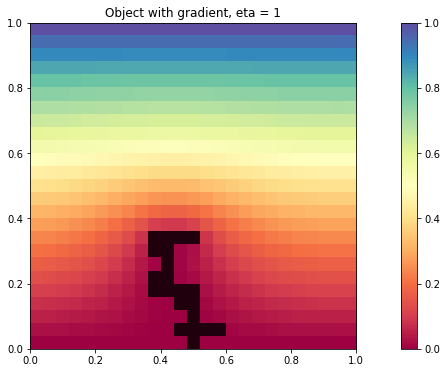

In [12]:
# test run

# initialise parameters
N = 25
eta = 1 
omega = 1.5
iterations = 20

conc_mat, object_array, totaliterations, object_array = SOR_DLA_to_solution(N, eta,omega, iterations)
plot_object_gradient(conc_mat, object_array, 1)

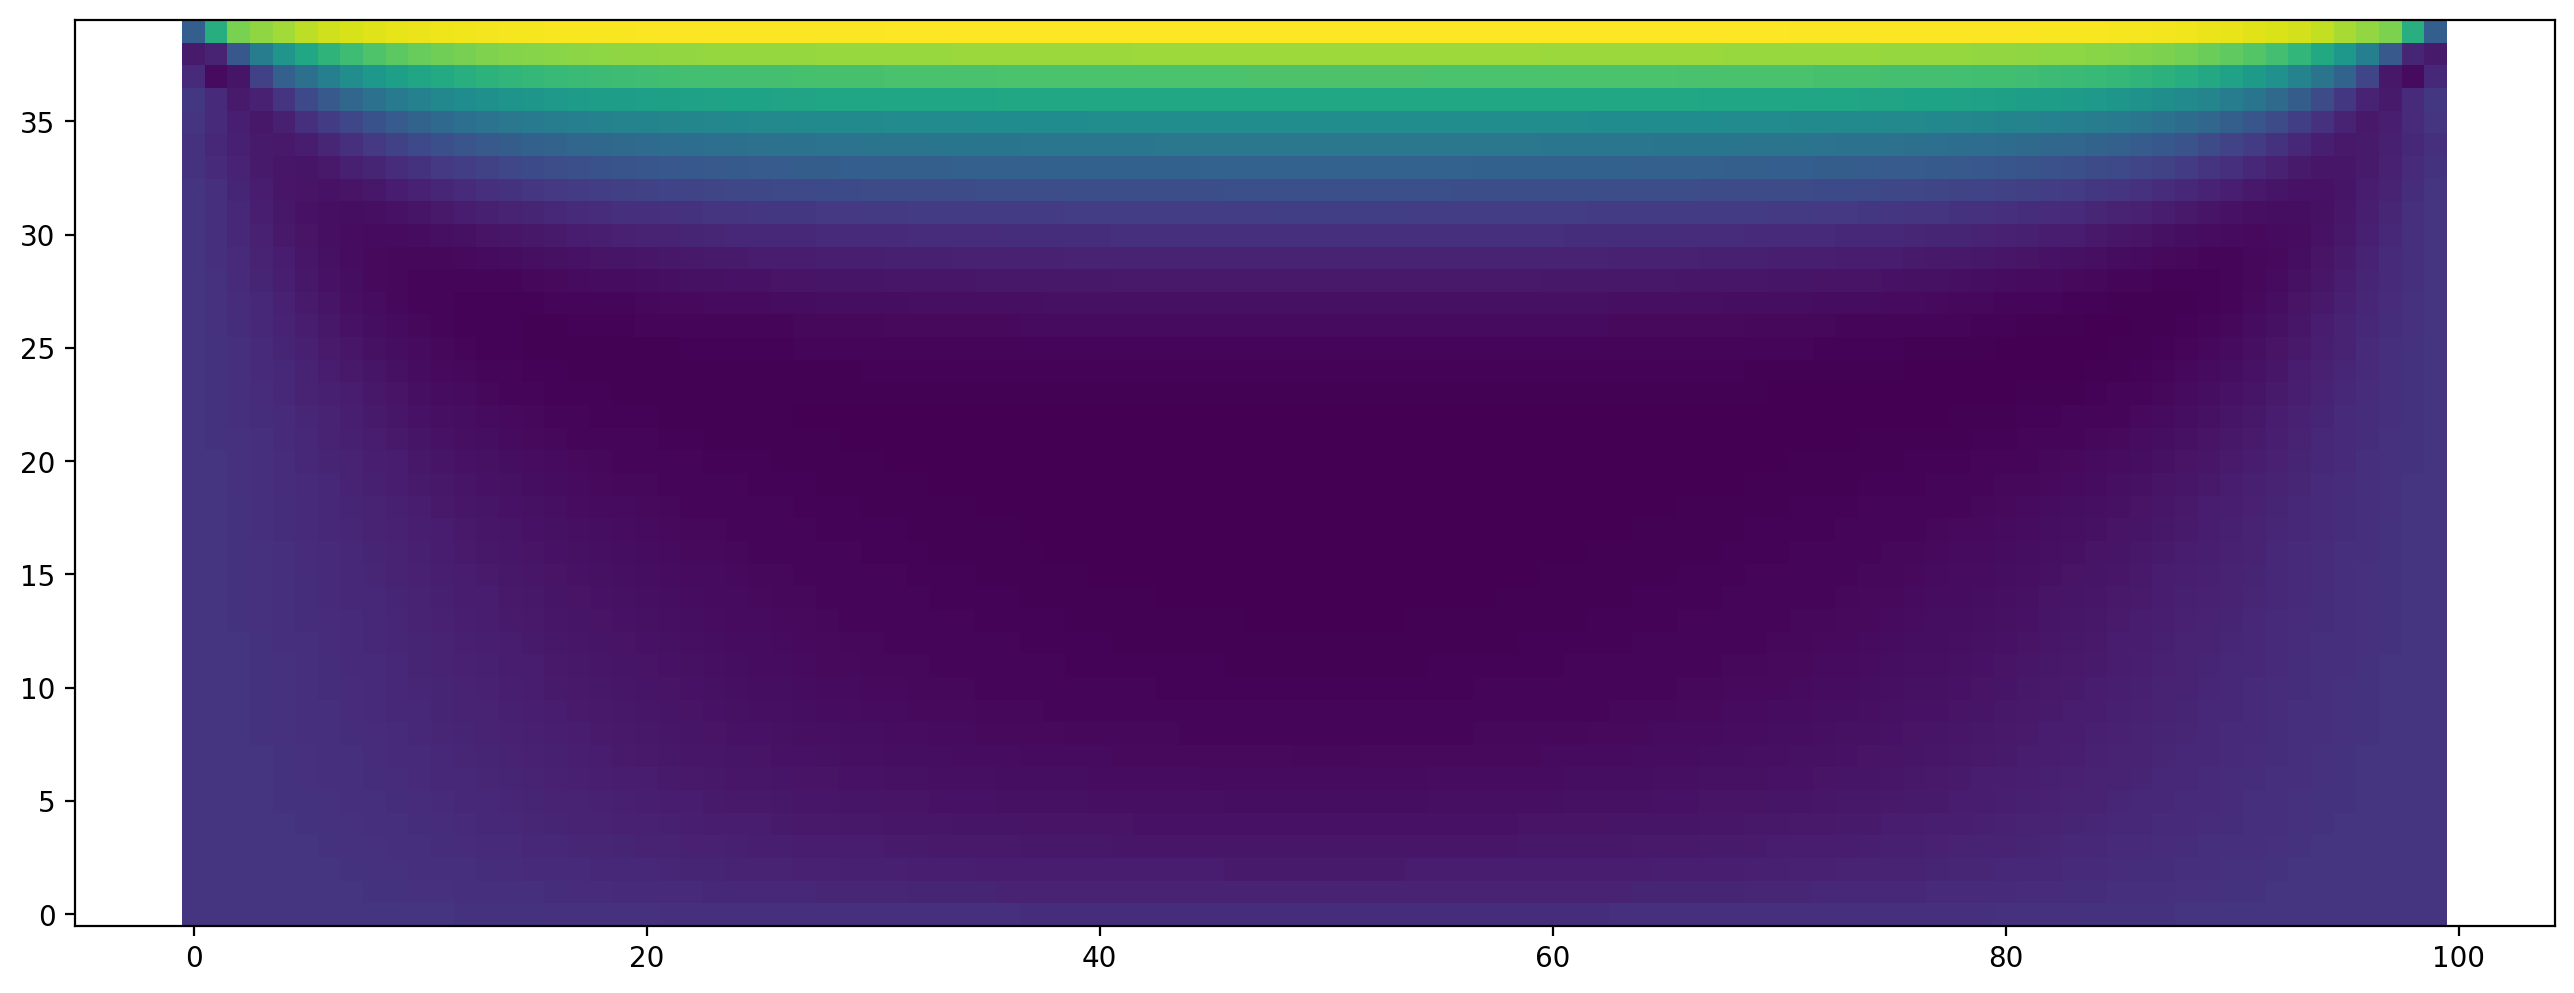

In [13]:
import pystencils
import sympy
from lbmpy.session import *
# example lid driven cavity
ldc = create_lid_driven_cavity(domain_size=(100, 40), method='srt', relaxation_rate=1.6)

ldc.run(500)
plt.figure(dpi=200)
#plt.vector_field(ldc.velocity_slice());

plt.scalar_field(ldc.velocity[:, :, 0])

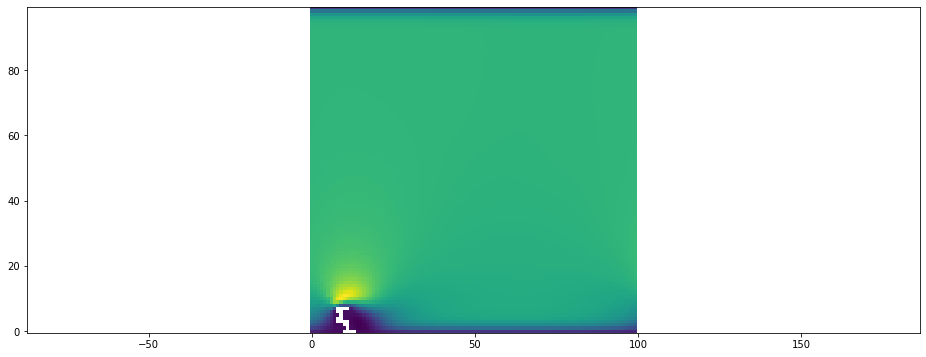

In [14]:
scenario = create_channel(domain_size=(100,100), force=1e-4, duct=True, method='srt', relaxation_rate=1.9)
#flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[0.3:0.4, 0.0:0.3])
#print(np.where(object_array==1))

for j in range(N-1):
    for i in range(1,N-1):
        # if part of object, concentration is zero
            if object_array[i][j] == 1:
                flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[j, i])
                
scenario.run(500)

plt.figure()
plt.scalar_field(scenario.velocity[:,:,0])
# plt.vector_field(scenario.velocity_slice());

In [15]:

# The threshold which the pressure needs to reach before the coral breaks (disappears)
THRESHOLD = 0.005

def coral_breaky_breaky(coral_matrix, vector_field, copy=True):
    """
        Function that computes if the coral is gonna breaky breaky
        
        Tim waz ere
        
        Note: We assume that the seed is at (50, 0)
        
        Parameters:
          - coral_matrix: a numpy array of 0's and 1's that determine where
            the coral is
          - vector_field: (I assume?) een numpy array of 2D vectors
          - copy: If True, does not modify the original object but instead returns a new one
          
        Returns:
          - The coral matrix with the relevant pixels removed
          
        O.O does it work?
    """
    
    # Copy the matrix if the user so desires
    if copy:
        coral_matrix = coral_matrix.copy()
        
    # Loop through the coral matrix to find the corals
    for y in range(len(coral_matrix)):
        for x in range(len(coral_matrix[y])):
            if (x == 50 and y == 0) or coral_matrix[y][x] == 0: continue

            # Compute the pressure at this point (i.e., length of the vector)
            pressure = math.sqrt(vector_field[x, y][0] ** 2 + vector_field[x, y][1] ** 2)

            # If the pressure exceeds the threshold, remove the coral (:()
            if pressure > THRESHOLD:
                coral_matrix[y][x] = 0

    # We're done! Return the result
    return coral_matrix

In [ ]:
def coral_painty_painty(coral_matrix, copy=True):
    """
        Function that checks which pixels are still connected to the source,
        and removes them. Also returns a new list of potential growth
        candidates.
        
        Note: We assume that the seed is at (50, 0) and that a diagonal connection == no connection
        
        Parameters:
          - coral_matrix: a numpy array of 0's and 1's that determine where
            the coral is
          - copy: If True, does not modify the original object but instead returns a new one
        
        Returns:
        A tuple of:
          - The coral matrix, with all the unconnected pixels removed
          - A new list of growth candidates
    """
    
    # Copy the matrix if the user so desires
    if copy:
        coral_matrix = coral_matrix.copy()
        
    # Do a breadth-first search starting at the seed to see which pixels are connected to the seed
    coral_matrix[0][50] = 2
    to_do = [(50, 0)]
    candidates = set()
    while len(to_do) > 0:
        # Fetch the pixel to check
        x, y = to_do[0]
        to_do = to_do[1:]
        
        # Get the area around the pixel
        for neighbour in [(-1, 0), (0, 1), (1, 0), (0, -1)]:
            nx = x + neighbour[0]
            ny = y + neighbour[1]
            
            # Skip if the pixel is out-of-bounds
            if nx < 0 or nx > coral_matrix.shape[0] - 1 or ny < 0 or ny > coral_matrix.shape[1] - 1:
                continue
            
            # If the pixel is not a pixel, then store it as possible growth candidate
            if coral_matrix[ny][nx] == 0:
                # Uncomment for the correct candidates order
#                 candidates.add((nx, ny))
                candidates.add((ny, nx))
            
            # If it is an (unvisited) pixel, then mark as visited/connected and add it to the todo list
            if coral_matrix[ny][nx] == 1:
                # Mark the pixel as connected
                coral_matrix[ny][nx] = 2
                
                # Add to the queue
                to_do.append((nx, ny))
    
    # Go thru the matrix again and remove anything that's a 1
    coral_matrix[coral_matrix == 1] = 0
    # Convert the visited pixels back to 1's
    coral_matrix[coral_matrix == 2] = 1
    
    # Done!
    return coral_matrix, candidates

In [ ]:
def coral_density(coral_matrix):
    """
        Function that computes the average distance per pixel to the source
        for the entire coral.
        
        Parameters:
          - coral_matrix: a numpy array of 0's and 1's that determine where
            the coral is
        
        Returns:
        The average distance of the coral. The lower, the denser.
    """
    
    # Search through the coral
    total_distance = 0
    n_pixels = 0
    for y in range(len(coral_matrix)):
        for x in range(len(coral_matrix[y])):
            # If not a coral or the source block, then skip
            if (x == 50 and y == 0) or coral_matrix[y][x] != 1: continue
                
            # If coral, then compute the distance to the source block
            total_distance += math.sqrt((x - 50)**2 + (y - 0)**2)
            n_pixels += 1
    
    # To return the average distance, we return total / count
    return total_distance / n_pixels

In [ ]:
print(object_array[object_array>=1].shape)

In [ ]:
object_array_test = object_array.copy()

test_space = int(N / 4)
object_array_test[test_space, test_space] = 1
object_array_test[test_space + 1, test_space] = 1
object_array_test[test_space, test_space + 1] = 1
object_array_test[test_space, test_space] = 1
object_array_trimmed, candidates_trimmed = coral_painty_painty(object_array_test, True)

In [ ]:
scenario = create_channel(domain_size=(100,100), force=1e-4,duct=True, method='srt', relaxation_rate=1.9)
#flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[0.3:0.4, 0.0:0.3])
#print(np.where(object_array==1))


for j in range(N-1):
    for i in range(1,N-1):
        # if part of object, concentration is zero
            if object_array_test[i][j] == 1:
                flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[j,i])
scenario.run(500)

plt.figure()
plt.scalar_field(scenario.velocity[:,:,0])
# plt.vector_field(scenario.velocity_slice());

scenario = create_channel(domain_size=(100,100), force=1e-4,duct=True, method='srt', relaxation_rate=1.9)
#flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[0.3:0.4, 0.0:0.3])
#print(np.where(object_array==1))


for j in range(N-1):
    for i in range(1,N-1):
        # if part of object, concentration is zero
            if object_array_trimmed[i][j] == 1:
                flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[j,i])
scenario.run(500)

plt.figure()
plt.scalar_field(scenario.velocity[:,:,0])
# plt.vector_field(scenario.velocity_slice());

scenario = create_channel(domain_size=(100,100), force=1e-4,duct=True, method='srt', relaxation_rate=1.9)
#flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[0.3:0.4, 0.0:0.3])
#print(np.where(object_array==1))


for i, j in candidates_trimmed:
    flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[j,i])
scenario.run(500)

plt.figure()
plt.scalar_field(scenario.velocity[:,:,0])
# plt.vector_field(scenario.velocity_slice());

In [ ]:
print(coral_density(object_array_trimmed))